In [503]:
import h5py
import json
import numpy as np
import pandas as pd
from pathlib import Path
# USEFUL FUNCTION FOR DATA ANALYSIS #
def find_repo_root() -> Path:
    return next(p for p in Path.cwd().parents if (p / "pyproject.toml").exists())


def read_stats_df(stats_path: Path) -> pd.DataFrame:
    with h5py.File(stats_path, "r", swmr=True) as fh:
        dset = fh["stats"]
        dset.refresh()
        fieldnames = [s.decode("utf-8") for s in dset.attrs["fieldnames"]]
        return pd.DataFrame(dset[...], columns=fieldnames)


def read_state_df(state_path: Path) -> pd.DataFrame:
    with h5py.File(state_path, "r", swmr=True) as fh:
        dset_state = fh["state"]
        dset_time = fh["time"]
        dset_step = fh["step"]
        dset_state.refresh()
        dset_time.refresh()
        dset_step.refresh()
        state = dset_state[...]
        df = pd.DataFrame(state, columns=[f"x_{i}" for i in range(state.shape[1])])
        df.insert(0, "t", dset_time[...])
        df.insert(0, "step", dset_step[...])
        return df


def read_timings(timings_path: Path) -> dict:
    return json.loads(Path(timings_path).read_text())


def read_config(config_path: Path) -> dict:
    return json.loads(Path(config_path).read_text())


### Example on how to load the result of the simulation in a pandas DataFrame

In [504]:
# Get path where the results are
repo_root = find_repo_root()
folder_name = repo_root / "notebooks" / "prototyping"  

# Read output of the simulations
stats_df = read_stats_df(folder_name / "stats.h5")
state_df = read_state_df(folder_name / "state.h5")
# parameters = read_config(folder_name / "config_used.json")
# timings = read_timings(folder_name / "timings.json")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/niccolo/Desktop/Dynamics_Networks/notebooks/prototyping/stats.h5', errno = 2, error message = 'No such file or directory', flags = 40, o_flags = 0)

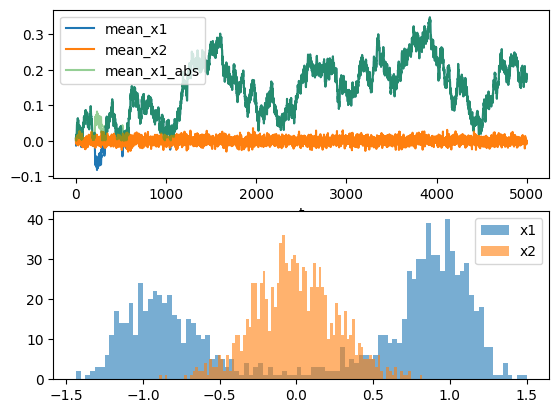

In [505]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
stats_df.plot(x="t", y="mean_x1", ax=ax[0])
stats_df.plot(x="t", y="mean_x2", ax=ax[0])
stats_df.assign(mean_x1_abs=stats_df["mean_x1"].abs()).plot(x="t", y="mean_x1_abs", ax=ax[0], alpha=0.5)

# Empirical measure at a single time snapshot (last recorded step).
snapshot = state_df.iloc[-1]
state_cols = [c for c in state_df.columns if c.startswith("x_")]
state = snapshot[state_cols].to_numpy()
x1 = state[0::2]
x2 = state[1::2]

bins = int(3 * np.sqrt(x1.size))
ax[1].hist(x1, bins=bins, alpha=0.6, label="x1")
ax[1].hist(x2, bins=bins, alpha=0.6, label="x2")
ax[1].legend()


## Phase diagram

Aggregate the sweep results and plot order parameter vs. theta.


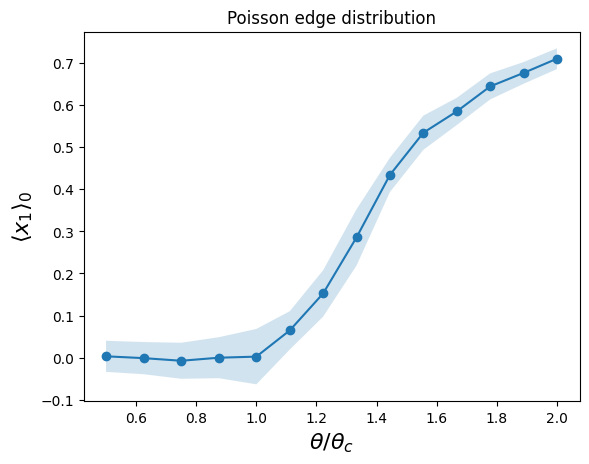

In [ ]:
from matplotlib import pyplot as plt
from dyn_net.utils.criticality import find_theta_c_from_degree_distribution


# Summarize mean_x1 and its variance over the tail window; optionally use abs for ordered phase.
def summarize_mean_x1(stats_path: Path, frac: float = 0.8, use_abs: bool = False) -> dict:
    df = read_stats_df(stats_path)
    if "mean_x1" not in df.columns:
        raise ValueError("mean_x1 column missing from stats.")
    if "t" not in df.columns:
        raise ValueError("t column missing from stats.")
    t_max = float(df["t"].max())
    t_start = frac * t_max
    tail = df[df["t"] >= t_start]
    if tail.empty:
        raise ValueError("No samples in tail window; check frac/t_max.")
    series = tail["mean_x1"].abs() if use_abs else tail["mean_x1"]
    return {
        "mean_x1": float(series.mean()),
        "var_x1": float(series.var(ddof=1)),
        "t_start": float(tail["t"].iloc[0]),
        "t_end": float(tail["t"].iloc[-1]),
    }


# Build a per-run table by reading each run folder's config_used.json.
def build_phase_diagram(
    sweep_dir: Path,
    *,
    frac: float = 0.8,
    theta_c: float | None = None,
    abs_above_theta_c: bool = False,
) -> pd.DataFrame:
    sweep_dir = Path(sweep_dir)
    rows = []
    for run_dir in sorted(sweep_dir.iterdir()):
        if not run_dir.is_dir():
            continue
        config_path = run_dir / "config_used.json"
        stats_path = run_dir / "stats.h5"
        if not (config_path.exists() and stats_path.exists()):
            continue
        config_used = read_config(config_path)
        theta = float(config_used["system"]["params"]["theta"])
        use_abs = abs_above_theta_c and theta_c is not None and theta > theta_c
        summary = summarize_mean_x1(stats_path, frac=frac, use_abs=use_abs)
        rows.append({
            "run": run_dir.name,
            "theta": theta,
            "use_abs": use_abs,
            **summary,
        })
    return pd.DataFrame(rows)


# Use a representative config in the sweep to compute theta_c.
def compute_theta_c_from_sweep(sweep_dir: Path, *, theta_bracket=(1e-6, 1.0)) -> float:
    for run_dir in sorted(Path(sweep_dir).iterdir()):
        if not run_dir.is_dir():
            continue
        config_path = run_dir / "config_used.json"
        if not config_path.exists():
            continue
        config_used = read_config(config_path)
        degree_distribution = config_used["network"]["params"]["degree_distribution"]
        sigma = float(config_used["noise"]["params"]["sigma"])
        return find_theta_c_from_degree_distribution(
            degree_distribution=degree_distribution,
            sigma=sigma,
            theta_bracket=theta_bracket,
        )
    raise ValueError("No config_used.json found in sweep_dir")


# Aggregate across reps for each theta and plot the mean_x1 order parameter.
sweep_dir = repo_root / "results/sweep_theta_double_well_configuration_model_local"

theta_c = compute_theta_c_from_sweep(sweep_dir)
abs_above_theta_c = True

phase_df = build_phase_diagram(
    sweep_dir,
    frac=0.8,
    theta_c=theta_c,
    abs_above_theta_c=abs_above_theta_c,
)
phase_summary = phase_df.groupby("theta", as_index=False).agg(
    mean=("mean_x1", "mean"),
    var=("var_x1", "mean"),
    t_start=("t_start", "mean"),
    t_end=("t_end", "mean"),
)
phase_summary["std"] = np.sqrt(phase_summary["var"])
phase_summary["theta_scaled"] = phase_summary["theta"] / theta_c

ax = phase_summary.plot(x="theta_scaled", y="mean", marker="o", legend=False)
ax.fill_between(
    phase_summary["theta_scaled"],
    phase_summary["mean"] - phase_summary["std"],
    phase_summary["mean"] + phase_summary["std"],
    alpha=0.2,
)
ax.set_ylabel(r"$\langle x_1 \rangle_0$", size=16)
ax.set_xlabel(r"$\theta / \theta_c$", size=16)
ax.set_title("Poisson edge distribution")
plt.show()
